# Class 16:  Bayesian Networks
## Infer a Bayesian network from a matrix of discretized phospho-flow cytometry data.
### Based on supplementary data from the 2005 article by Karen Sachs et al. (Science v308, 2005). 

In this class exercise, we will use the fundamental theorem for the likelihood of a Bayesian network structure for categorical variables, in order to score the posterior probability of the network shown in the Sachs et al. article (Figure 3A) vs. the phospho-flow cytometry data that the same authors provided in their supplementary data. The phospho-flow cytometry data have been already discretized for you (see "class16_bayesnet_dataprep_R.ipynb").  We will need to implement a single-vertex log-likelihood function using Theorem 1 from the article by Cooper & Herskovits in *Machine Learning* (volume 9, pages 309-347, 1992).

For this notebook, we will need a bunch of python modules

In [10]:
import numpy
import pandas
import math
import scipy.special
import igraph
import itertools
import matplotlib.pyplot

Load the tab-delimited data file of discretized phosphoprotein expression data (12 columns; first 11 columns are the expression levels -- "low", "medium", "high"; last column is the experiment identifier for the row; there are nine experiments). Print out the first six lines of the data frame, so you can see what it looks like.

In [1]:
g_discret_data = pandas.read_csv("shared/sachs_data_discretized.txt",
                                 sep="\t")
g_discret_data.head(n=6)

,praf,pmek,plcg,PIP2,PIP3,p44.42,pakts473,PKA,PKC,P38,pjnk,expt
0,low,low,low,low,high,low,low,medium,medium,high,high,1_cd3cd28
1,low,low,medium,low,low,medium,medium,medium,low,low,high,1_cd3cd28
2,medium,high,medium,low,medium,medium,medium,medium,medium,medium,medium,1_cd3cd28
3,medium,high,medium,low,low,low,low,medium,medium,medium,medium,1_cd3cd28
4,low,medium,low,low,medium,medium,medium,low,low,medium,high,1_cd3cd28
5,low,low,medium,low,low,medium,medium,medium,medium,high,high,1_cd3cd28


Define a log likelihood function for the vertex degree distribution. Compute a vector `degarray_float` of floating point values for the degree of each vertex. The log likelihood is the logarithm of the product (over all vertices) of the single-vertex power-law degree distribution, which we will define as 1/(1+k)^2. Remember that the log of the product is the sum of the logs, so you can just compute this as `numpy.sum` of `numpy.log` of `numpy.power(1.0 + degarray_float, -2)`

In [2]:
def log_prob_network_prior(network):
    degarray = numpy.sum(network, axis=0) + numpy.sum(network, axis=1)
    degarray_float = numpy.zeros(len(degarray))
    degarray_float[:] = degarray
    return numpy.sum(numpy.log(numpy.power(1.0 + degarray_float, -2)))

Define a vectorized log-factorial function, since it doesn't seem to be a builtin in python. Use the fact that factorial(n) = gamma(n+1), where `gamma` means the gamma function. Note that we can compute log gamma as `scipy.special.gammaln`.

In [3]:
def lfactorial(n):
    return scipy.special.gammaln(n+1)

Define a log likelihood function for a single vertex, based on Theorem 1 in the 1992 article in *Machine Learning* by Cooper & Herskovits. Note:  we are using igraph's adjacency matrix format which is the transpose of Newman's adjacency matrix definition!

In [4]:
def log_likelihood_network_vertex(network, vertex, discret_data):
    # network is a NxN numpy matrix (N = 11 vertices)
    # vertex is an integer
    # discret_data is "g_discret_data" (N = 11 vertices, M = 7466 samples)
    parents_vertex = numpy.where(network[:,vertex]==1)[0].tolist()
    all_vertices = parents_vertex.copy()
    all_vertices.append(vertex)
    df1 = discret_data.iloc[:, all_vertices] 

    # change the name of the vertex column to "vertex"
    df1_column_names = df1.columns.tolist()
    df1_column_names[len(parents_vertex)] = "vertex"
    df1.columns = df1_column_names

    # count the data, grouped by all columns (parents & vertex)
    df1 = df1.groupby(df1.columns.values.tolist()).size().reset_index(name='count')
    
    # make a new column called "count factorial" that is the log of the factorial of the count
    df1["countfactorial"] = lfactorial(df1["count"].values)
    
    # drop the "count" column, as we no longer need it
    df1 = df1.drop("count", 1)
    
    if len(parents_vertex) > 0:

        # sum up log-factorial-counts values for all possible states of "vertex" and its parent vertices, 
        # for each possible combination of parent vertices
        nijkdf = df1.groupby(by=df1.columns[list(range(0,len(parents_vertex)))].tolist(), 
                    as_index=False).sum()
        
        # count number of cells with each possible combination of states for its parent vertices
        df3 = discret_data.iloc[:, parents_vertex]
        nijdf = df3.groupby(df3.columns.values.tolist(), as_index=False).size().reset_index()
        nijdf_col_names = nijdf.columns.values
        nijdf_col_names[len(nijdf_col_names)-1] = "count"
        nijdf.columns = nijdf_col_names
        
        # compute the log factorial of the counts
        nijdf["countfactorial"] = math.log(2) - lfactorial(2 + nijdf["count"])
        
        # drop the "count" column as we no longer need it
        nijdf = nijdf.drop("count", 1)
        
        # merge the two log-factorial-count values from nijdf and nijkdf, into two columns in a single dataframe
        nmerge = nijdf.merge(nijkdf, how="outer", 
                     on=nijkdf.columns[0:(len(nijkdf.columns)-1)].values.tolist(),
                     copy=False)
        
        # sum the log-factorial-count values from nijdf and nijkdf
        llh_res = numpy.sum(nmerge["countfactorial_x"] + nmerge["countfactorial_y"])
    else:
        # we handle the case of no parent vertices specially, to simplify the code
        M = discret_data.shape[0]
        llh_res = math.log(2) - lfactorial(M + 2) + numpy.sum(df1["countfactorial"].values)
    return llh_res

Define a log-posterior-probability function for the whole graph, using the per-vertex likelihood and the network structure prior:

In [5]:
def log_posterior_prob_network(network, discret_data):
    Nvert = network.shape[1]
    lpvert_values = []
    for i in range(0, Nvert):
        lpvert_value = log_likelihood_network_vertex(network, i, discret_data)
        lpvert_values.append(lpvert_value)
    return log_prob_network_prior(network) + numpy.sum(numpy.array(lpvert_values))

Define an adjacency matrix for the "real" network shown in Fig. 3A of the Sachs et al. article (not including the "missed" edges which are the dotted arcs).

In [6]:
real_network_adj_np = numpy.zeros(shape=[11,11])
molec_names = list(g_discret_data.columns)[0:11]
real_network_adj_df = pandas.DataFrame(real_network_adj_np, index=molec_names, columns=molec_names)
real_network_adj_df["PKA"]["PKC"] = 1
real_network_adj_df["praf"]["PKC"] = 1
real_network_adj_df["pjnk"]["PKC"] = 1
real_network_adj_df["P38"]["PKC"] = 1
real_network_adj_df["pjnk"]["PKA"] = 1
real_network_adj_df["P38"]["PKA"] = 1
real_network_adj_df["praf"]["PKA"] = 1
real_network_adj_df["pmek"]["PKA"] = 1
real_network_adj_df["p44.42"]["PKA"] = 1  # p44.42 = ERK
real_network_adj_df["pakts473"]["PKA"] = 1
real_network_adj_df["pakts473"]["p44.42"] = 1
real_network_adj_df["pmek"]["PKC"] = 1
real_network_adj_df["pmek"]["praf"] = 1
real_network_adj_df["p44.42"]["pmek"] = 1
real_network_adj_df["PIP2"]["plcg"] = 1
real_network_adj_df["PIP3"]["plcg"] = 1
real_network_adj_df["PIP2"]["PIP3"] = 1
real_network_adj = real_network_adj_df.values

Make an igraph network out of the adjacency matrix that you just created, and print the network summary and plot the network.

In [7]:
real_network_igraph = igraph.Graph.Adjacency(real_network_adj.tolist())
real_network_igraph.summary()

'IGRAPH D--- 11 17 -- '

Compute the log posterior probability of the real network `real_network_adj` from Sachs *et al.* Figure 3A, using your function `log_posterior_prob_network`.

In [8]:
lp_real = log_posterior_prob_network(real_network_adj, g_discret_data)
print(lp_real)

-84131.03111133902


Generate 1000 random rewirings of the network -- eliminating any rewired digraphs that contain cycles -- and for each randomly rewired network compute the log posterior probability. Use `igraph.Graph.rewire_edges(prob=1, loops=False, multiple=False)` to randomly rewire the graph. Make sure to make a copy of the graph before you rewire it. Check that the rewired graph is a DAG using `igraph.Graph.is_dag()`. If it is a DAG, compute the log posterior probability of the network using `log_posterior_prob_network`. You can get the adjacency matrix for the random graph as a numpy array using `numpy.array(randgraph.get_adjacency().data)`  

In [12]:
lprobs_rand = []
for _ in itertools.repeat(None, 1000):
    graphcopy = real_network_igraph.copy()
    graphcopy.rewire_edges(prob=1, loops=False, multiple=False)
    if graphcopy.is_dag():
        lprobs_rand.append(log_posterior_prob_network(numpy.array(graphcopy.get_adjacency().data), 
                                                      g_discret_data))

Histogram the log ratio of the "real" network's posterior probability to the posterior probabilities of each of the random networks. Does it appear that the published network is a reasonable approximation to the maximum *a posteriori* (MAP) estimate?  

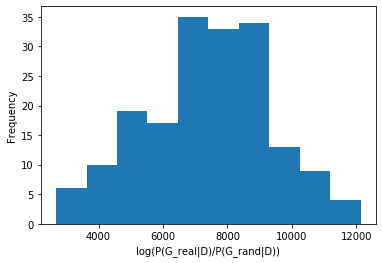

In [13]:
import matplotlib.pyplot
matplotlib.pyplot.hist(lp_real - lprobs_rand)
matplotlib.pyplot.xlabel("log(P(G_real|D)/P(G_rand|D))")
matplotlib.pyplot.ylabel("Frequency")
matplotlib.pyplot.show()